# Actividad grupal: Usos reales de filtros espaciales y morfológicos

## Introduccion

La morfología es un estudio de la forma y la estructura. En el procesamiento de imágenes, se utiliza para analizar y modificar propiedades geométricas de una imagen probándola con diferentes formas. Las características geométicas de estas formas, llamadas elementos estructurales, conduce a medidas cuantitativas que son útiles en la visión informática. El proceso es similar a la convolución lineal y la correlación, excepto que las operaciones lógicas AND, OR, y NOT se utilizan en un área en lugar de operaciones aritméticas. Los píxeles se añaden a un objeto o se eliminan de él. Hay que definir la extensión del área, y los elementos de estructurales, los cuales pueden ser rotados por 180º.

En la operación de la convolución, con máscaras hechas de diferentes tipos de respuestas de impulso, podemos procesar señales con diferentes filtros como paso bajo y paso alto. De manera similar, con diferentes tipos de elementos de estructurales y la realización de la convolución con operadores lógicos, podemos realizar diversos tipos de análisis de objetos. Aunque su uso primario es con imágenes binarias, la morfología también se extiende a las imágenes a escala gris.

En el presente caso utilizamos imagenes de rayos X, que por la naturaleza de las mismas presentan alto contraste y escalas de grises. Estas imágenes corresponden directamente a consulta médica donde existió un agente extraño en el cuerpo humano y con las operaciones de filtros morfológicos pretendemos hacer más sencilla su determinación de posible diagnóstico y tratamiento médico. Las imágenes presentaron resultados favorables para las operaciones en cuestión.


## Librerias a utilizar

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

## Imágenes usadas

En estas tres imágenes `img_0` representa una imagen de control, mientras que `img_1` y `img_2` corresponden imágenes a rayos X.

In [2]:
img_0 = cv.imread('im/unir-1.jpg', cv.IMREAD_GRAYSCALE)
img_1 = cv.imread('im/dental-1.jpg', 0)
img_2 = cv.imread('im/dental-2.jpg', 0)

## Implementación de operadores morfológicos

La dilatación suele generar un efecto de ampliación del objeto en una imágen, llegando a eliminar algunos detalles que se consideren mínimos o ajenos al objeto que conforma la mayor parte de la composición de la misma. La erosión genera un efecto contrario, el cual amplia los detalles mínimos encontrados ajenos al agente principal de la imagen, minimizando el objeto que tenga mayor presencia en la misma.

Ambas operaciones se pueden ciclar e iterar en la forma que convenga para obtener un efecto deseado en determinado tipo de imágenes.

En las operaciones de apertura y dilatación, la imagen es sujeta a dilatación y erosión. La diferencia es el orden de estas operaciones. La operación de apertura abre pequeñas brechas entre tocar objetos en una imagen mientras la operación de cierre cierra pequeñas brechas en un objeto.

Se llama apertura si la dilatación es precedida por la erosión. Si la dilatación es seguida de la erosión se llama cierre. 

In [3]:
def padding(originalImg, padSize):
    padImg = np.zeros((rows+2*padSize, columns+2*padSize), dtype=np.uint8)
    # recortando
    padImg[padSize:rows+padSize, padSize:columns+padSize] = originalImg
    return padImg

In [4]:
def Erosion(padImg, kernel, size):
    output = np.zeros((rows, columns), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, columns):
            # recortando
            portion = padImg[i:i+size, j:j+size]
            # se suma el elemento estructural y la ventana
            portion1 = portion.flatten()
            portion2 = kernel.flatten()
            p1 = (np.sum(portion1))
            p2 = (np.sum(portion2))*255
            # la condicional para que no revase el limite
            if p1 == p2:
                output[i, j] = 255
            else:
                output[i, j] = np.min(portion1)
    return output

In [5]:
def Dilatacion(padImg, size):
    output = np.zeros((rows, columns), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, columns):
            # recortando
            portion = padImg[i:i+size, j:j+size]
            portion1 = portion.flatten()
            # la condicional para que no revase el limite
            if 255 in portion1:
                output[i, j] = 255
            else:
                output[i, j] = np.max(portion1)
    return output

In [6]:
def opening(padImg, kernel, size):
    # Se aplica la erosion
    erosion = Erosion(padImg, kernel , size)
    padImg2 = padding(erosion, size//2)
    # Se aplica al dilatacion
    output = Dilatacion(padImg2, size)
    return output

In [7]:
def closing(padImg,kernel, size):
    # Se aplica al dilatacion
    dilation = Dilatacion(padImg, size)
    padImg2 = padding(dilation, size//2)
    # Se aplica la erosion
    output = Erosion(padImg2, kernel, size)
    return output

## Uso
### Definición de parámetros

In [8]:
#Numero de elementos de la mascara a utilizar
size = 9
#Elemento estructural
kernel = np.ones((size, size), np.uint8)
#Tamaño del padding
p_size = size//2

### Operaciones

In [10]:
# Selección de la imagen a utilizar, es posible cambiarla por otras
orginalImg = img_0
#Se obtiene los tamaños de la imagen original
rows = orginalImg.shape[0]
columns = orginalImg.shape[1]
#Se obtiene el padding inicial
padImg = padding(orginalImg, p_size)
#Aplicamos las operaciones morfológicas
Dil = Dilatacion(padImg, size)
Ero = Erosion(padImg, kernel, size)
Clo = closing(padImg, kernel, size)
Opn = opening(padImg, kernel, size)

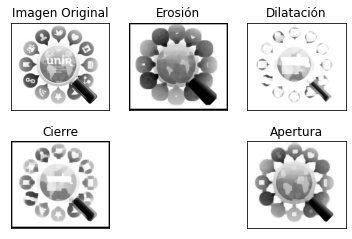

In [11]:
orginalImg = cv.cvtColor(orginalImg, cv.COLOR_BGR2RGB)
Ero = cv.cvtColor(Ero, cv.COLOR_BGR2RGB)
Dil = cv.cvtColor(Dil, cv.COLOR_BGR2RGB)
Clo = cv.cvtColor(Clo, cv.COLOR_BGR2RGB)
Opn = cv.cvtColor(Opn, cv.COLOR_BGR2RGB)
plt.subplot(231)
plt.imshow(orginalImg)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(232)
plt.imshow(Ero)
plt.title('Erosión'), plt.xticks([]), plt.yticks([])
plt.subplot(233)
plt.imshow(Dil)
plt.title('Dilatación'), plt.xticks([]), plt.yticks([])
plt.subplot(234)
plt.imshow(Clo)
plt.title('Cierre'), plt.xticks([]), plt.yticks([])
plt.subplot(236)
plt.imshow(Opn)
plt.title('Apertura'), plt.xticks([]), plt.yticks([])
plt.show()

## Aplicación

Una vez que se ha observado el efecto sobre una imagen de control, se aplicaron los filtros a las imágenes de Rayos X de interés. Sin embargo, solo se obtuvieron resultados parcialmente favorables. Las operaciones eliminaron elementos que no son de interés pero no permitian ver con claridad la profundidad de otros elementos.

In [12]:
# Selección de la imagen a utilizar, es posible cambiarla por otras
orginalImg = img_2
#Se obtiene los tamaños de la imagen original
rows = orginalImg.shape[0]
columns = orginalImg.shape[1]
#Se obtiene el padding inicial
padImg = padding(orginalImg, p_size)
#Aplicamos las operaciones morfológicas
Dil = Dilatacion(padImg, size)
Ero = Erosion(padImg, kernel, size)
Clo = closing(padImg, kernel, size)
Opn = opening(padImg, kernel, size)

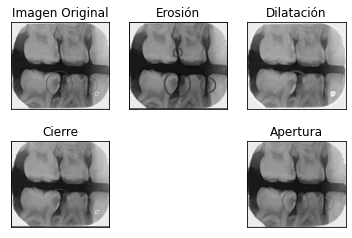

In [13]:
orginalImg = cv.cvtColor(orginalImg, cv.COLOR_BGR2RGB)
Ero = cv.cvtColor(Ero, cv.COLOR_BGR2RGB)
Dil = cv.cvtColor(Dil, cv.COLOR_BGR2RGB)
Clo = cv.cvtColor(Clo, cv.COLOR_BGR2RGB)
Opn = cv.cvtColor(Opn, cv.COLOR_BGR2RGB)
plt.subplot(231)
plt.imshow(orginalImg)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(232)
plt.imshow(Ero)
plt.title('Erosión'), plt.xticks([]), plt.yticks([])
plt.subplot(233)
plt.imshow(Dil)
plt.title('Dilatación'), plt.xticks([]), plt.yticks([])
plt.subplot(234)
plt.imshow(Clo)
plt.title('Cierre'), plt.xticks([]), plt.yticks([])
plt.subplot(236)
plt.imshow(Opn)
plt.title('Apertura'), plt.xticks([]), plt.yticks([])
plt.show()

### Gradiante morfológico

El gradiante morfológico es resultado de restar la imagen erosionada a la imágen dilatada. El resultado es una imagen usada en la segmentación debido a que cada valor de píxel (por lo general no negativo) indica la intensidad de contraste en la vecindad de ese píxel. Con esta operación se ha conseguido el efecto deseado.

In [ ]:
# Selección de la imagen a utilizar, es posible cambiarla por otras
orginalImg = img_1
#Se obtiene los tamaños de la imagen original
rows = orginalImg.shape[0]
columns = orginalImg.shape[1]
#Se obtiene el padding inicial
padImg = padding(orginalImg, p_size)
#Aplicamos las operaciones morfológicas
Dil = Dilatacion(padImg, size)
Ero = Erosion(padImg, kernel, size)
Gradiante = Dil - Ero

In [ ]:
orginalImg = cv.cvtColor(orginalImg, cv.COLOR_BGR2RGB)
Ero = cv.cvtColor(Ero, cv.COLOR_BGR2RGB)
Dil = cv.cvtColor(Dil, cv.COLOR_BGR2RGB)
Gradiante = cv.cvtColor(Gradiante, cv.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(orginalImg)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(Gradiante)
plt.title('Gradiante'), plt.xticks([]), plt.yticks([])
plt.show()

## Conclusión

Las operaciones morfológicas básicas son dos: erosión y dilatación. Estas operaciones son se pueden combinar a conveniencia para obtener operaciones secundarias, como la apertura y el cierre, que pueden ser usados dependiendo del objetivo o necesidades del caso particular.

En la aplicación de los filtros puede verse que el gradiante morfológico permite distingir qué segmentos se encuentran más cercanos de otros en una imagen de rayos X, además de definir el área de dichos segmentos. Esto es importante por el efecto de transparencia que llegan a tener las imágenes de rayos X.